In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import networkx as nx
import scipy
from scipy import signal
import cmath

In [2]:
def construct_graph(p,  n_conn_nodes):
    g =  nx.watts_strogatz_graph(n_conn_nodes, 3, 0.5)  #param d modificare
    # adj = (nx.adjacency_matrix(g)).toarray()

    sel_sensors = sample_sensors(p, n_conn_nodes)
    d = dict(zip([i for i in g.nodes()], [int(sel_sensors[j]) for j in range(len(sel_sensors))]))
    g = nx.relabel_nodes(g, d)
    return g

def sample_sensors(p, n_conn_nodes):
    n = np.random.randint(0, p, size = n_conn_nodes)  #65 da modificare
    return n


def construct_theta_subblocks(m):
    block = np.eye(m)*0.2
    return block


def construct_precision_theta(p,m, g):
    delta = 1
    theta = np.eye((m*p))* delta

    for i in g.edges:
        # print(i)
        theta[i[0]*m:(i[0]+1)*m, i[1]*m:(i[1]+1)*m] = construct_theta_subblocks(m)
        theta[i[1]*m:(i[1]+1)*m, i[0]*m:(i[0]+1)*m] = construct_theta_subblocks(m) 

    while delta <= np.max(np.sum(abs(theta -np.eye(m*p)), axis=0)):
        # print(delta, np.max(np.sum(abs(theta -np.eye(m*p)), axis=0)))
        delta += 1

    theta =  theta + np.eye(m*p)*(delta-1)
    print(delta,np.max(np.sum(abs(theta -np.eye(m*p)), axis=0)))
    
    return theta

In [3]:

def define_func_score(p,m, mu, sigma):
    # mu \in R^{pm} ?
    # sigma = theta^(-1), theta \in R^{pm x om}   
    csi = np.random.multivariate_normal(np.zeros(m*p), sigma).reshape((m,p))

    #NB: di può decidere di richiamare la funzione precision matrix qui per creare theta ed invertirla (bisogna vedere se è utile avere theta nel codice, forse sì)
    return csi


def create_fourier_basis(t, freq_band):
    t = np.array(t)
    fb = np.ones((len(freq_band)*2,len(t)))*(-3)
    k=0
    for f in freq_band:
        fb[k, :] = np.sqrt(f)*np.cos(2*np.pi*f*t)
        fb[k+1, :] = np.sqrt(f)*np.sin(2*np.pi*f*t)
        k = k +2
    return fb    


def func_data(t, freq_band, p, mu, sigma):
    fb_vec = create_fourier_basis(t,freq_band).T   #NB non ottimale la generazione della base a ogni dato funzionale generato 
    # print(fb_vec.shape)
    csi_vec = define_func_score(p,len(freq_band)*2,mu,sigma)
    # print(csi_vec.shape)
    sm = np.matmul(fb_vec, (csi_vec))
    return sm.T, csi_vec

In [4]:
def fdata_sim(n1, n2, p, m,  freq_band, time, sigma_pop, sigma_group1):
    data = np.zeros((p, len(time), (n1+n2)))
    csi_vec_pop = np.zeros((m, p, (n1+n2)))
    csi_vec_group = np.zeros((m, p, (n1)))
    for i in range(n1+n2):
        data[:,:, i],  csi_vec_pop[:,:,i] = func_data(time, freq_band, p,  0, sigma_pop)  
        if i < n1:
            fd = func_data(time, freq_band, p,  0, sigma_group1)
            data[:, :, i] += fd[0]
            csi_vec_group[:,:,i]  = fd[1]

    return data, csi_vec_pop, csi_vec_group    #da sistemare questa cosaaaaaaaaa
            

1 0.6000000000000001
True


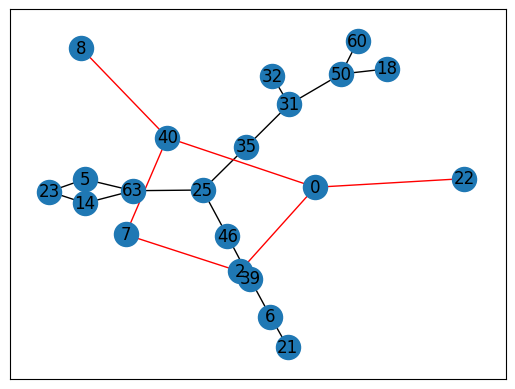

1 0.6000000000000001


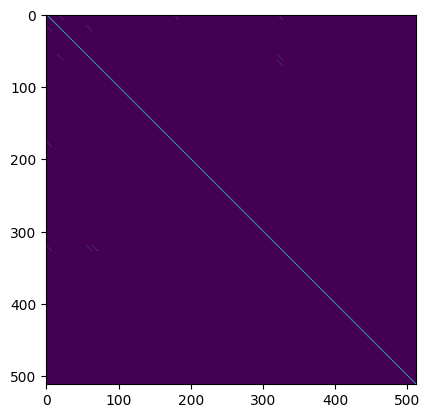

True


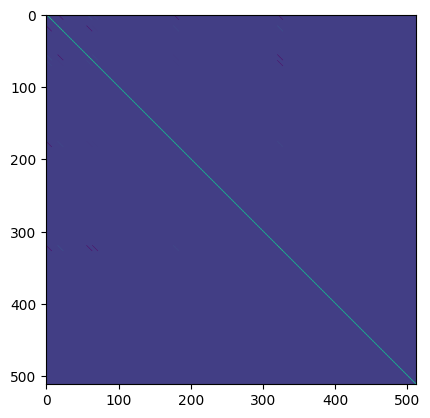

In [5]:
p = 64; freq = [9,10,11,12]; m= len(freq)*2; n_nodes_active_pop = 15; n_nodes_diff_group = 7
T =100;  nt= 10000; deltaT = 1/nt; n_sub1 = 3; n_sub2 = 2; n_sub = n_sub1 + n_sub2
time = np.linspace(0, T, nt)


g = construct_graph(p, n_nodes_active_pop)

# print(a)
nx.draw_networkx(g, with_labels = True)
# plt.show()
# plt.close()

tp = construct_precision_theta(p,m,g)
# plt.imshow(tp)
# plt.show()
# plt.close()


# while np.all(np.linalg.eigvals(tp) > 0) != True:
print(np.all(np.linalg.eigvals(tp) > 0))
sigma = np.linalg.inv(tp)

# plt.imshow(sigma)
# plt.show()
# plt.close()


g_diff = construct_graph(p, n_nodes_diff_group)
while len(np.intersect1d(list(g.nodes()), list(g_diff.nodes()))) != 0:
    g_diff = construct_graph(p, n_nodes_diff_group)


nx.draw_networkx(g_diff, with_labels = True, edge_color = 'r')
plt.show()
plt.close()
   

tp_g1 = construct_precision_theta(p,m,g_diff)
plt.imshow(tp_g1)
plt.show()
plt.close()

print(np.all(np.linalg.eigvals(tp_g1) > 0))
sigma_g1 = np.linalg.inv(tp_g1)
plt.imshow(sigma_g1)
plt.show()
plt.close()


d, csi_pop, csi_g = fdata_sim(n_sub1,n_sub2,p,m,  freq,time,sigma, sigma_g1)   #da risistemare

# d, csi = func_data(time, freq, p, 0, sigma)

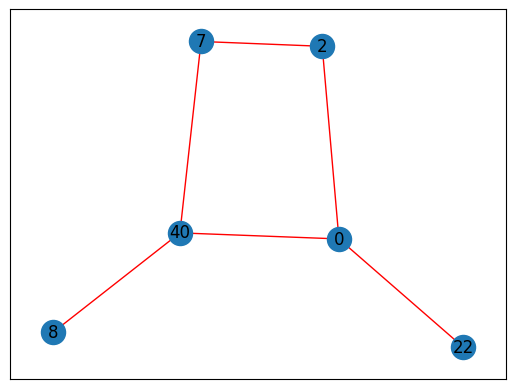

In [22]:
nx.draw_networkx(g_diff, with_labels = True, edge_color = 'r')
plt.savefig("fig_prova.png")
plt.show()
plt.close()

In [50]:
np.savetxt('prova2.txt', np.array(list(g.edges)).astype(int), fmt='%i')

In [47]:
np.array(list(g.edges)).astype(int)

array([[25, 46],
       [25, 63],
       [25, 35],
       [21,  6],
       [ 6, 39],
       [39, 46],
       [18, 50],
       [50, 31],
       [50, 60],
       [31, 35],
       [31, 32],
       [63, 14],
       [63,  5],
       [14, 23],
       [23,  5]])

In [29]:
nx.adjacency_matrix(g).toarray()

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [6]:
csi_pop.shape

(8, 64, 5)

In [7]:
csi_g.shape

(8, 64, 3)

In [8]:
d.shape

(64, 10000, 5)

In [10]:
for i in range(n_sub):
    np.save("sim_data/scores_prova_p_"+str(i), csi_pop[:,:,i])
    np.save("sim_data/fd_prova_scores_"+str(i), d[:,:, i])
    if i < n_sub1:
            np.save("sim_data/scores_prova_g_"+str(i), csi_g[:,:,i])

In [ ]:
# csi[:,0]

# for i in range(n_sub):
# np.savetxt("sim_data/scores_prova.txt", csi[:,0])

In [ ]:
# csi_ord = np.array([csi[0,0]/(np.sqrt(9)), csi[1,0]/(np.sqrt(9)), csi[2,0]/(np.sqrt(10)), csi[3,0]/(np.sqrt(10)), csi[4,0]/(np.sqrt(11)), csi[5,0]/(np.sqrt(11)),
#     csi[6,0]/(np.sqrt(12)), csi[7,0]/(np.sqrt(12))])

# csi_ord

In [ ]:
# csi_ord2 = np.array([csi[0,0]*(np.sqrt(9)), csi[1,0]*(np.sqrt(9)), csi[2,0]*(np.sqrt(10)), csi[3,0]*(np.sqrt(10)), csi[4,0]*(np.sqrt(11)), csi[5,0]*(np.sqrt(11)),
#     csi[6,0]*(np.sqrt(12)), csi[7,0]*(np.sqrt(12))])
# csi_ord2

In [ ]:
# for i in range(n_sub):
# np.save("sim_data/fd_prova_scores", d[0,:])

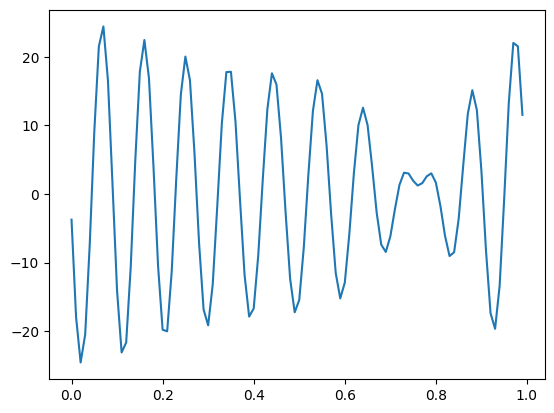

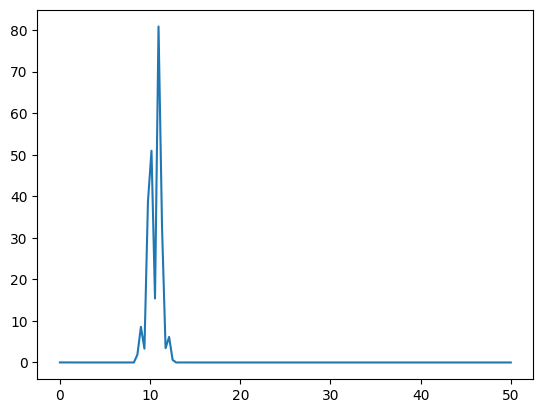

In [15]:
#esempio di visualizzazione


n_ch  = 0

# ff, spettro = signal.welch(d[n_ch,:, 0], scaling = 'spectrum')
ff, spettro = signal.welch(d[:,:, n_ch], scaling = 'spectrum')

# plt.plot(time, d[n_ch,:, 0])
plt.plot(time[0:100], d[0,0:100, n_ch])
plt.show()
plt.close()
plt.plot( ff*T, spettro[0,:])


In [21]:
np.max(csi_g[:,:,0])

np.float64(2.8855192708960384)

In [ ]:
n_sub = 1
save_scores = np.ones((n_sub, p*m))

for jj in range((n_sub)):
    f = np.fft.fft(d, axis = 1)
    coeffs_real = np.real(f)
    coeffs_imag = np.imag(f)
    xfreq = scipy.fft.fftfreq(len(d[0,:]), d=deltaT)
    # plt.plot(xfreq[800:1300], f[0,800:1300])
    # plt.show()
    # plt.close()
    for k in range(p):                      
        for i in range(len(freq)):
            save_scores[jj, (i)*2+k*m] = coeffs_real[k, freq[i]*T]  ##??? 
            save_scores[jj, i*2 +1+k*m] = coeffs_imag[k, freq[i]*T]

In [ ]:
f.shape

In [ ]:
plt.plot(xfreq, coeffs_real[0,:])

In [ ]:
plt.scatter( time, coeffs_real[0,:]/100)

In [ ]:
coeffs_real[0,0:15]

In [ ]:
csi[:,0]

In [ ]:
#alcolo degli scores e salvataggio
# n_sub = 1
# save_scores = np.ones((n_sub, p*m))

# for jj in range((n_sub)):
#     f = np.fft.fft(d[:,:,jj], axis = 1)
#     coeffs_real = np.real(f)
#     coeffs_imag = np.imag(f)
#     xfreq = scipy.fft.fftfreq(len(d[0,:,jj]), d=deltaT)
#     # plt.plot(xfreq[800:1300], f[0,800:1300])
#     # plt.show()
#     # plt.close()
#     for k in range(p):                      
#         for i in range(len(freq)):
#             save_scores[jj, (i)*2+k*m] = coeffs_real[k, freq[i]*T]  ##??? 
#             save_scores[jj, i*2 +1+k*m] = coeffs_imag[k, freq[i]*T]

In [ ]:
coef_n = coeffs_real
coef_n[0, 0:50]

In [ ]:
0.01*100

In [ ]:
f.shape

In [ ]:
coef_n[0, :50]

In [ ]:
143/np.sqrt(9)

In [ ]:
np.arange(10)

In [ ]:
3 * np.exp(-2j * np.pi * 1 * np.arange(0,10,1)/10)

connectivity computation

In [ ]:
import mne, mne_connectivity
epochs = mne.make_fixed_length_epochs(f[:,:,0])   #epochs
mne_connectivity.spectral_connectivity_epochs(epochs,  method='imcoh', mode = 'multitaper', sfreq = 0.01, fmin=8, fmax=13, faverage=True)

prove


In [ ]:
prova2 = np.fft.fft(d[0,:,0])

coeffs_real = np.real(prova2)
coeffs_imag = np.imag(prova2)

xfreq = scipy.fft.fftfreq(len(d[0,:,0]), d=deltaT)

save_scores = np.zeros((len(freq)*2, 1))
for i in range(len(freq)):
    save_scores[i*2] = coeffs_real[freq[i]*T]
    save_scores[i*2 +1] = coeffs_imag[freq[i]*T]


plt.plot(xfreq[800:1300], prova2[800:1300]  )
# plt.plot(xfreq, coeffs_real)

In [ ]:
save_scores = np.zeros((len(freq)*2, 1))
for i in range(len(freq)):
    # print(i)
    print(i*2, coeffs_real[freq[i]*100])
    print(i*2+1, coeffs_imag[freq[i]*100])
    s = 0.5*(abs(coeffs_real[freq[i]*100]) - abs(coeffs_imag[freq[i]*100]))
    print(s)
    save_scores[i*2] = coeffs_real[freq[i]*100]
    save_scores[i*2 +1] = coeffs_imag[freq[i]*100]


print(save_scores)

In [ ]:
np.sqrt((save_scores[0]**2+ save_scores[1]**2))

In [ ]:
a_ikm = np.sum(d[0,:,0] *np.array(np.sqrt(9)*np.cos(2*np.pi*9*time)))*(T/nt)
a_ikm

In [ ]:
(d[0,:,0] *np.array(np.sqrt(9)*np.cos(2*np.pi*9*time))).shape

In [ ]:
r2 = 0.5*(prova2[900] + np.conj(prova2[nt-900]))
r2

In [ ]:
i2 = 1/(2j)*(prova2[900] - np.conj(prova2[nt-900]))
i2

In [ ]:
prova2[900]

In [ ]:
abs(r2+i2)

In [ ]:
prova2[900] 

In [ ]:
np.conj(prova2[nt-900])

In [ ]:
nt-900

In [ ]:
# sigma = np.linalg.inv(tp)
# plt.imshow(sigma)
# plt.close()

time = np.linspace(0,100,10000)
# test = create_fourier_basis(time,  freq)
# np.array(test).shape
# test.T
# 
s = func_data(time, freq, p,  0, sigma)
plt.plot(time, s.T);
# np.std(data)

print(time)
print(np.mean(s, axis = 1))
print(s.shape)

In [ ]:
from scipy import signal

n_ch = 1
ff, spettro = signal.welch(s[n_ch,:], scaling = 'spectrum')

plt.plot(time, s[n_ch,:])
plt.show()
plt.close()
plt.plot( ff*100, spettro)
